In [283]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

symbols = ["NVDA", "AMD", "INTC", "AVGO", "QCOM", "MU"]   ### These stocks tend to be correlated
data = {}

for sym in symbols:
    ticker = yf.Ticker(sym)
    df = ticker.history(interval="1m", period="2d")
    df = df[['Close']].rename(columns={'Close': sym})
    data[sym] = df

df_all = pd.concat(data.values(), axis=1, join='inner')

df_all_local = df_all.tz_convert('US/Eastern')

# Get yesterday's date in US Eastern Time
yesterday = pd.Timestamp.now(tz='US/Eastern').normalize() - pd.Timedelta(days=1)

# Filter rows where the local date is yesterday
df_yesterday = df_all_local[df_all_local.index.normalize() == yesterday]




In [359]:
cov_matrix = df_yesterday.cov()

###Select non-zero covariance pairs
pairs = []
for i, sym1 in enumerate(symbols):
    for j, sym2 in enumerate(symbols):
        if j <= i:
            continue
        cov_value = cov_matrix.loc[sym1, sym2]
        if abs(cov_value) > 1e-10:
            pairs.append((sym1, sym2, cov_value))

# 4. Regression residuals stationarity test
stationary_pairs = []

for sym1, sym2, cov_value in pairs:
    y = df_all[sym1]        # dependent
    x = df_all[sym2]        # independent

    # Add constant for intercept
    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit()

    # Get intercept (alpha) and slope (beta)
    alpha = model.params['const']
    beta = model.params[sym2]

    # Residuals = y - (alpha + beta*x)
    residuals = y - model.predict(x_with_const)

    # ADF test on residuals
    result = adfuller(residuals.dropna())
    p_value = result[1]

    if p_value < 0.05:  # Stationary residuals
        stationary_pairs.append((sym1, sym2, cov_value, p_value, alpha, beta))

# Display pairs that are stationary correlated
for sp in stationary_pairs:
    print(f"{sp[0]}-{sp[1]} | Cov: {sp[2]:.4f} | p={sp[3]:.4f} | alpha={sp[4]:.4f} | beta={sp[5]:.4f}")


AMD-INTC | Cov: 0.0007 | p=0.0136 | alpha=427.5299 | beta=-12.1837
AMD-MU | Cov: -0.0124 | p=0.0024 | alpha=-248.6100 | beta=3.8048
INTC-AVGO | Cov: -0.0809 | p=0.0211 | alpha=38.0111 | beta=-0.0588
INTC-QCOM | Cov: -0.0222 | p=0.0043 | alpha=49.6960 | beta=-0.1795
INTC-MU | Cov: -0.0117 | p=0.0075 | alpha=43.4826 | beta=-0.2046
QCOM-MU | Cov: 0.0618 | p=0.0006 | alpha=40.1457 | beta=1.0907


In [385]:
def thresholds_pairs(stationary_pairs):
    pairs_mean_lb_ub = []
    for sp in stationary_pairs:
        if np.round(10* sp[5]) == 0:
            print('zero beta')
            continue
        df_station = 10 * df_yesterday[sp[0]] -  np.round(10* sp[5]) * df_yesterday[sp[1]]
        pairs_mean_lb_ub.append({
            'pair1': sp[0],
            'pair2': sp[1],
            'mean': np.mean(df_station),
            'lb': np.percentile(df_station, 5),
            'ub': np.percentile(df_station, 95),
            'number shares pair2': np.round(10*sp[5])
        })
    return pairs_mean_lb_ub


In [373]:
np.round(10*stationary_pairs[3][5]*10)

-18.0

In [391]:
pairs = thresholds_pairs(stationary_pairs)
pairs

[{'pair1': 'AMD',
  'pair2': 'INTC',
  'mean': 4270.484990119934,
  'lb': 4252.010051727295,
  'ub': 4298.071934700012,
  'number shares pair2': -122.0},
 {'pair1': 'AMD',
  'pair2': 'MU',
  'mean': -2485.8706071598012,
  'lb': -2498.197511291504,
  'ub': -2463.2191429138184,
  'number shares pair2': 38.0},
 {'pair1': 'INTC',
  'pair2': 'AVGO',
  'mean': 500.970196723938,
  'lb': 499.79420280456543,
  'ub': 502.5082353591919,
  'number shares pair2': -1.0},
 {'pair1': 'INTC',
  'pair2': 'QCOM',
  'mean': 530.4144252206861,
  'lb': 528.4249988555908,
  'ub': 532.143236541748,
  'number shares pair2': -2.0},
 {'pair1': 'INTC',
  'pair2': 'MU',
  'mean': 430.13921758317457,
  'lb': 428.6766445159912,
  'ub': 431.8900018692017,
  'number shares pair2': -2.0},
 {'pair1': 'QCOM',
  'pair2': 'MU',
  'mean': 390.4453659254251,
  'lb': 383.3922794342041,
  'ub': 396.0914638519287,
  'number shares pair2': 11.0}]

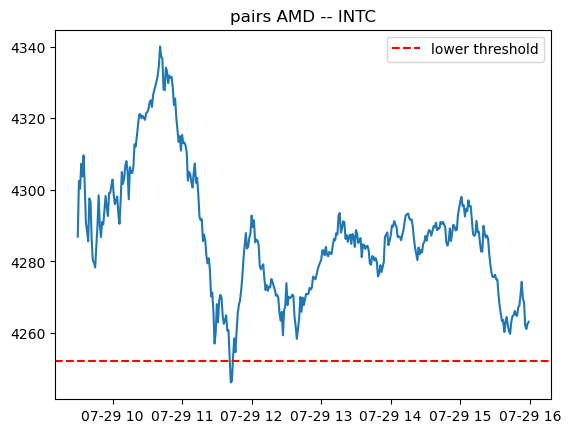

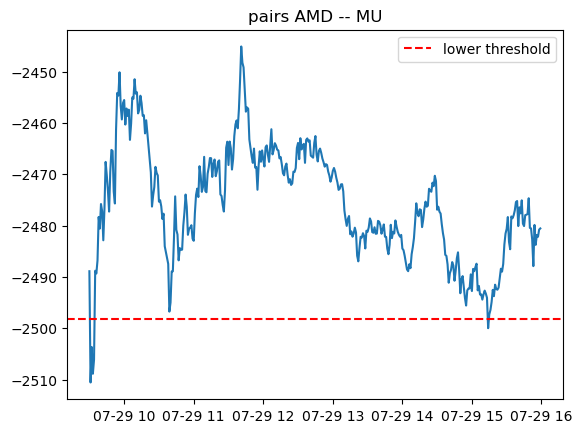

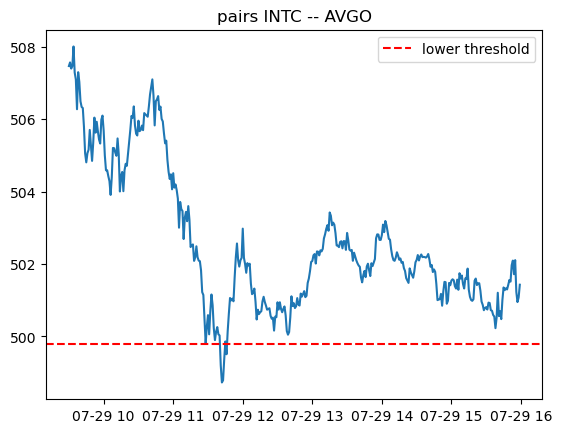

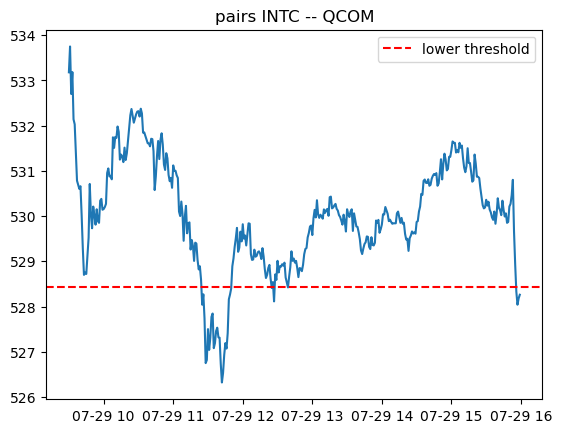

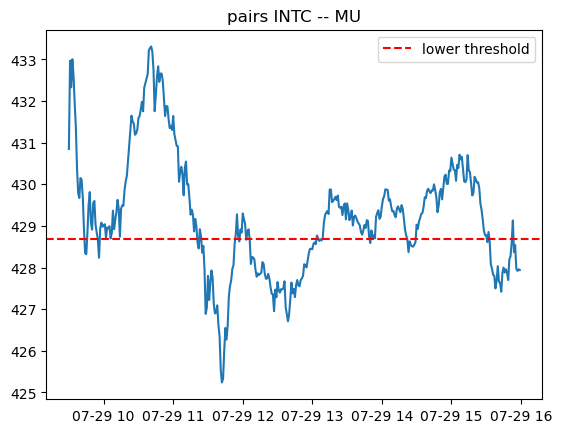

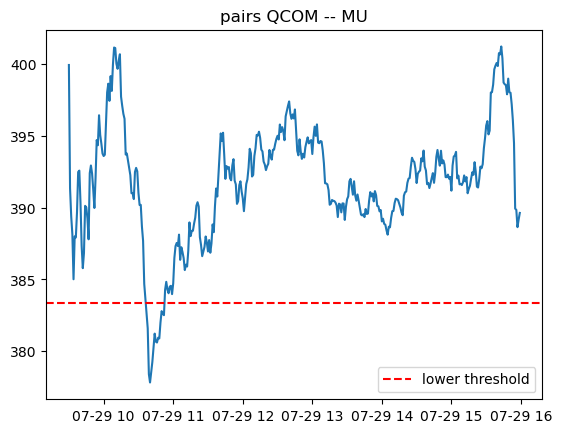

In [403]:
start = "2025-07-29 09:30"
end = "2025-07-29 16:00"

# Plot the data in the time window
for p2 in pairs:
    price_pairs = 10*df_all[start:end][p2['pair1']]- p2['number shares pair2'] * df_all[start:end][p2['pair2']]
    plt.plot(price_pairs)
    plt.axhline(y=p2['lb'], color='red', linestyle='--', label = "lower threshold")
    plt.title(f"pairs {p2['pair1']} -- {p2['pair2']}")
    plt.legend()
    plt.show()

